In [1]:
import cv2
import dlib
import numpy as np
import sys
import matplotlib.pyplot as plt
from google.colab import drive

Before running following codes, please make sure that you have already uploaded the data of interest (including videos of interest and shape_predictor_68_face_landmarks.dat) to your own Google drive, and that you change to the correct depository where the videos reside by editing cd 'path_for_video'.

In [7]:
# Mount to Google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
cd '/content/drive/My Drive/video_swap'

/content/drive/My Drive/video_swap


In [25]:
def get_img_gray(source, des):
  """ Change images to grayscale. Return grayscale images. """
  source_g = cv2.cvtColor(source, cv2.COLOR_BGR2GRAY)
  des_g = cv2.cvtColor(des, cv2.COLOR_BGR2GRAY)
  return source_g, des_g

def get_model(predictor_path):
  """ Return the model which predicts the 68 landmarks of a human face."""
  detector = dlib.get_frontal_face_detector()
  predictor = dlib.shape_predictor(predictor_path)
  return detector, predictor

def get_index_triangle(points,triangles):
  """Return the corresponding triangle indexes for each point in the image."""
  indexes_triangles = []
  for t in triangles:
      side1 = (t[0], t[1])
      side2 = (t[2], t[3])
      side3 = (t[4], t[5])

      point_indices = []
      for i in range(0, len(points)):
          # if the convex hull points and the triangle points are close enough, 
          # add the indices to the list of triangles
          if abs(side1[0] - points[i][0]) + abs(side1[1] - points[i][1]) <= 2:
              point_indices.append(i)
          if abs(side2[0] - points[i][0]) + abs(side2[1] - points[i][1]) <= 2:
              point_indices.append(i)
          if abs(side3[0] - points[i][0]) + abs(side3[1] - points[i][1]) <= 2:
              point_indices.append(i)

          indexes_triangles.append(point_indices)

  return indexes_triangles

def process_source_img(img_gray):
    """Return the coordinates of the bound box of the human face of the source image, the landmark coordinates, 
    and triangle indexes for each landmark point of the source image."""
    eta = 10
    mask = np.zeros_like(img_gray)
    total_graphs = detector(img_gray) 
    #print("source",total_graphs[0])
    if len(total_graphs) == 0: return None, False, False 

    if check_boundaries(total_graphs) == False:
      left = total_graphs[0].left()
      top = total_graphs[0].top()
      right = total_graphs[0].right()
      bottom = total_graphs[0].bottom()
      if left <= 0:
        left = eta
      if right <= 0:
        right = eta
      if top <= 0:
        top = eta
      if bottom <= 0:
        bottom = eta
      total_graphs = dlib.rectangles()
      total_graphs.append(dlib.rectangle(left,top,right,bottom))
    for face in total_graphs:
        landmarks = predictor(img_gray, face)
        landmarks_points = []

        #dlib library will return 68 points, stored as landmarks 
        for n in range(0, 68):
            landmarks_points.append((landmarks.part(n).x, landmarks.part(n).y))

        points = np.array(landmarks_points, np.int32)
        convexhull = cv2.convexHull(points)
        cv2.fillConvexPoly(mask, convexhull, 255)

        # do Delaunay triangulation only on the source img
        # than link the corresponding points in destination img
        rect = cv2.boundingRect(convexhull)
        subdiv = cv2.Subdiv2D(rect)
        subdiv.insert(landmarks_points)
        triangles = np.array(subdiv.getTriangleList(), dtype=np.int32)
        indexes_triangles = get_index_triangle(points, triangles)

    
    return  total_graphs, landmarks_points, indexes_triangles


def process_replace_img(img_gray):
    """Return the coordinates of the bound box of the human face of the target image, the landmark coordinates, 
    and triangle indexes for each landmark point of the target image."""
    eta = 10
    total_graphs2 = detector(img_gray)   
    if len(total_graphs2) == 0: return None, False, False

    # If the detected human face is out of image boundary, then by replacing the negative coordinates with
    # a positive threshold, there will be less mishandled Delaunay triangles, and thus lead to a better result.
    if check_boundaries(total_graphs2) == False:
      left = total_graphs2[0].left()
      top = total_graphs2[0].top()
      right = total_graphs2[0].right()
      bottom = total_graphs2[0].bottom()
      if left <= 0:
        left = eta
      if right <= 0:
        right = eta
      if top <= 0:
        top = eta
      if bottom <= 0:
        bottom = eta
      total_graphs2 = dlib.rectangles()
      total_graphs2.append(dlib.rectangle(left,top,right,bottom))

    for face in total_graphs2:
        landmarks = predictor(img_gray, face)
        landmarks_points2 = []
        for n in range(0, 68):
            landmarks_points2.append((landmarks.part(n).x,landmarks.part(n).y))
        #convert landmark_points to integer for convexHull function
        points2 = np.array(landmarks_points2, np.int32)
        
    return total_graphs2, landmarks_points2, cv2.convexHull(points2)

def show_triangles(triangles, img):
  """Visualization of Delaunay triangles."""
  img_show = img.copy()
  for t in triangles:
    pt1 = (t[0], t[1])
    pt2 = (t[2], t[3])
    pt3 = (t[4], t[5])
    cv2.line(img_show, pt1, pt2, (255, 255, 255), 1)
    cv2.line(img_show, pt2, pt3, (255, 255, 255), 1)
    cv2.line(img_show, pt1, pt3, (255, 255, 255), 1)
  show_rgb(img_show)

def triangle2points(landmarks_points,triangle_index):
    """Return the Delaunay triangles coordinates."""
    #use the triangle index to get the triangle points 
    triangle_pt1 = landmarks_points[triangle_index[0]]
    triangle_pt2 = landmarks_points[triangle_index[1]]
    triangle_pt3 = landmarks_points[triangle_index[2]]
    triangle = []
    triangle.append(triangle_pt1)
    triangle.append(triangle_pt2)
    triangle.append(triangle_pt3)
    triangle = np.array(triangle, np.int32)

    # subtract the x and y seperately to get points with offset
    (x, y, size_1, size_2) = cv2.boundingRect(triangle)
    offset_points = []
    offset_points.append([triangle_pt1[0] - x, triangle_pt1[1] - y])
    offset_points.append([triangle_pt2[0] - x, triangle_pt2[1] - y])
    offset_points.append([triangle_pt3[0] - x, triangle_pt3[1] - y])
    points = np.array(offset_points, np.int32)
    return triangle, points

def affine_triangle(points, points2, triangle2, cropped_triangle):
  """Return warped triangles by using affine transformation."""
  (x, y, size_1, size_2) = cv2.boundingRect(triangle2)
  tr2_mask = np.zeros((size_2, size_1), np.uint8)
  cv2.fillConvexPoly(tr2_mask, points2, 255)

  affine_transform = cv2.getAffineTransform(np.float32(points), np.float32(points2))
  warped_triangle = cv2.warpAffine(cropped_triangle, affine_transform, (size_1, size_2))
  warped_triangle = cv2.bitwise_and(warped_triangle, warped_triangle, mask=tr2_mask)
  return warped_triangle

def triangulation(source, des, indexes_triangles, landmarks_points, landmarks_points2):
    """ The function of Delaunay triangulation, integrating other functions. Return the warped image."""
    img2_new_face = np.zeros_like(des)
    cc=0
    total = 0
    for triangle_index in indexes_triangles:
        triangle1, points = triangle2points(landmarks_points,triangle_index)
        (x, y, size_1, size_2) = cv2.boundingRect(triangle1)
        cropped_triangle = source[y: y + size_2, x: x + size_1]
        h,w,c = cropped_triangle.shape
        total+=1
        if h == 0 or w == 0 or c==0:
          cc+=1
          continue
        triangle2, points2 = triangle2points(landmarks_points2,triangle_index)
        (x, y, size_1, size_2) = cv2.boundingRect(triangle2)
        # similar to project 5, get affine transform and warp triangles to warp the image 
        warped_triangle = affine_triangle(points, points2, triangle2, cropped_triangle)

        # cut and paste to rebuild the destination face
        rect = img2_new_face[y: y + size_2, x: x + size_1]
        rect_g = cv2.cvtColor(rect, cv2.COLOR_BGR2GRAY)

        _, mask1= cv2.threshold(rect_g, 1, 255, cv2.THRESH_BINARY_INV) 
        rect = cv2.add(rect, cv2.bitwise_and(warped_triangle, warped_triangle, mask=mask1))
        img2_new_face[y: y + size_2, x: x + size_1] = rect
    return img2_new_face

def get_mask(des_gray, convexhull2):
  """Return the mask of interest for a given image."""
  mask1 = np.zeros_like(des_gray)
  mask2 = cv2.fillConvexPoly(mask1, convexhull2, 255)
  # plt.imshow(mask1)
  # plt.show()
  # plt.imshow(cv2.bitwise_not(mask1))
  # plt.show()
  return cv2.bitwise_not(mask1), mask2

def swap_face(des_gray, convexhull2, img2_new_face, des):
    """Return the blending image after the Poisson blending."""
    # compute masks use convex function
    face_mask, head_mask = get_mask(des_gray, convexhull2)
  
    noface = cv2.bitwise_and(des, des, mask=face_mask)
    # show_rgb(noface)
    result = cv2.add(noface, img2_new_face)
    # show_rgb(result)

    # Seamless Cloning
    (x, y, size_1, size_2) = cv2.boundingRect(convexhull2)
    center = (int(x + (size_1) / 2), int(y + (size_2) / 2))  
    return cv2.seamlessClone(result, des, head_mask, center, cv2.NORMAL_CLONE)

def show_landmarks(ld_points, img):
  """Visualization of facial landmarks."""
  # print(landmark_points)
  img_show = img.copy()
  for (x,y) in ld_points:
    cv2.circle(img_show, (x,y), radius=0, color=(255, 255, 255), thickness=2)
  show_rgb(img_show)
  
def show_rgb(img):
  """Helper function: Return the RGB mode of an image."""
  #cv2 using plt.show will raise error and we need to rearrange rgb layer's order
  b,g,r = cv2.split(img)           # get b, g, r
  rgb_img = cv2.merge([r,g,b]) 
  plt.imshow(rgb_img)
  plt.show()

def check_boundaries(graph):
  """Helper function: check if  a detected human face is out of image boundary."""
  left = graph[0].left()
  top = graph[0].top()
  right = graph[0].right()
  bottom = graph[0].bottom()
  if left <= 0 or right <= 0 or top <= 0 or bottom <= 0:
    return False
  else:
    return True

Begin face swapping...


***********************************************************************************************


We've done  20  frames.
facial landmarks:


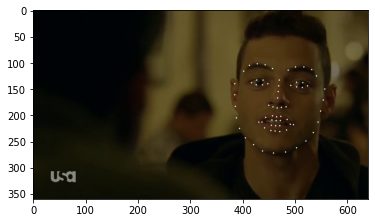

Result image:


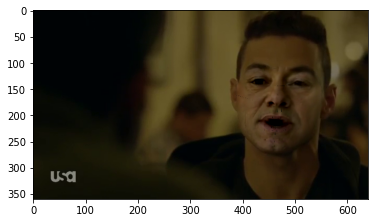



***********************************************************************************************


We've done  40  frames.
facial landmarks:


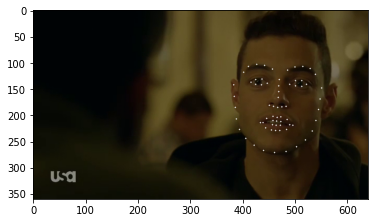

Result image:


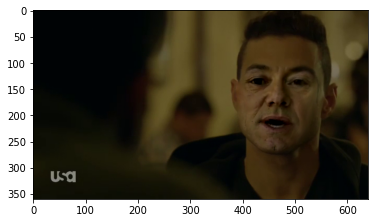



***********************************************************************************************


We've done  60  frames.
facial landmarks:


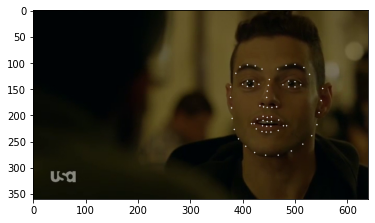

Result image:


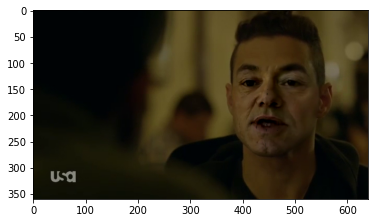



***********************************************************************************************


We've done  80  frames.
facial landmarks:


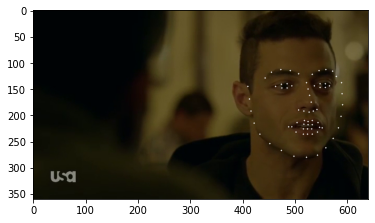

Result image:


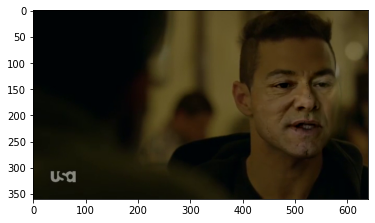



***********************************************************************************************


We've done  100  frames.
facial landmarks:


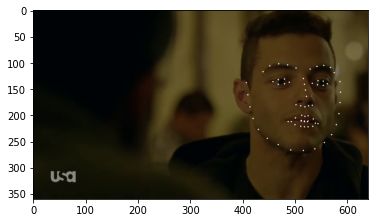

Result image:


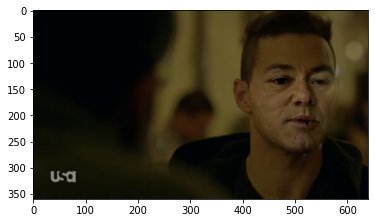



***********************************************************************************************


We've done  120  frames.
facial landmarks:


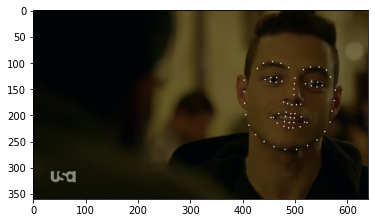

Result image:


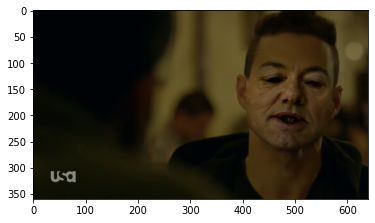



***********************************************************************************************


We've done  140  frames.
facial landmarks:


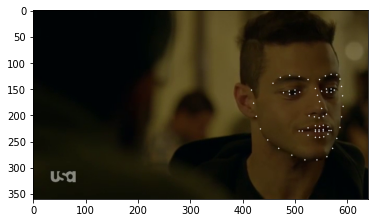

Result image:


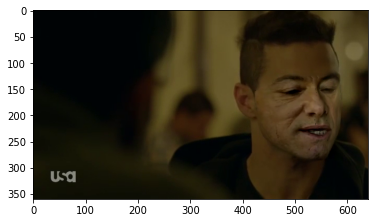



***********************************************************************************************


We've done  160  frames.
facial landmarks:


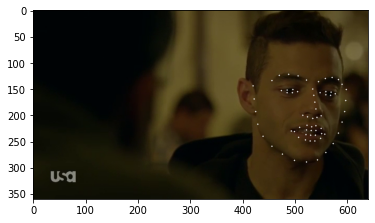

Result image:


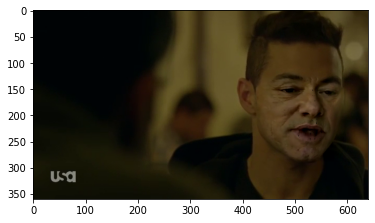



***********************************************************************************************


We've done  180  frames.
facial landmarks:


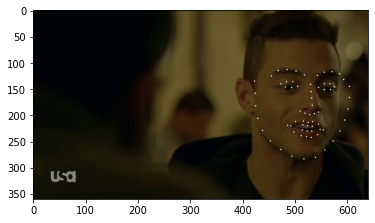

Result image:


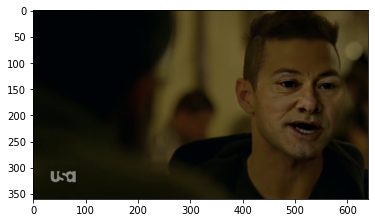



***********************************************************************************************


We've done  200  frames.
facial landmarks:


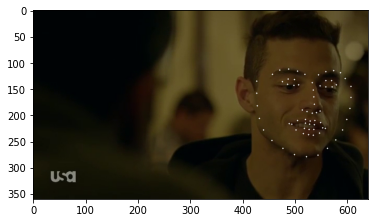

Result image:


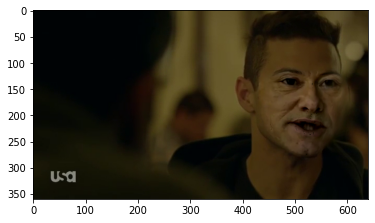



***********************************************************************************************


We've done  220  frames.
facial landmarks:


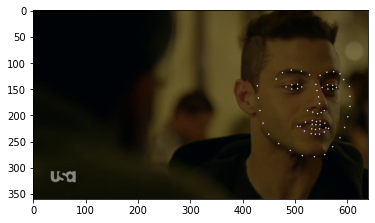

Result image:


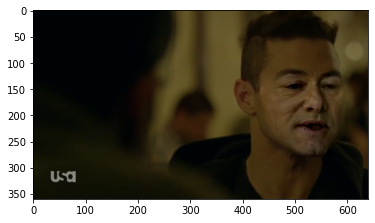



***********************************************************************************************
End face swapping...


In [30]:
detector, predictor = get_model("/content/drive/MyDrive/video_swap/shape_predictor_68_face_landmarks.dat")
cap1 = cv2.VideoCapture('/content/drive/MyDrive/video_swap/Data/FrankUnderwood.mp4')
cap2 = cv2.VideoCapture('/content/drive/MyDrive/video_swap/Data/MrRobot.mp4')

i=1
frame_width = int(cap2.get(3))
frame_height = int(cap2.get(4))
out = cv2.VideoWriter('/content/drive/MyDrive/video_swap/Data/OutputVideo.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 24, (frame_width,frame_height))
print("Begin face swapping...")
print('\n')    
print('***********************************************************************************************')
while(True):
    ret_src,srcc = cap1.read()
    ret_des,des = cap2.read()
    if(ret_des==False or ret_src==False):
        print("End face swapping...")
        break
    source_g, des_g = get_img_gray(srcc, des) 
    g1, landmarks_points, indexes_triangles = process_source_img(source_g)
    g2, landmarks_points2, convexhull2 = process_replace_img(des_g)
    # Somtimes the detector cannot successfully detects a human face if the face is presented in the image. If the 
    #face is not detected, we skip this frame.
    if landmarks_points==False or landmarks_points2 == False: continue
    # Show feature detection results
    img2_new_face = triangulation(srcc,des, indexes_triangles, landmarks_points, landmarks_points2)
    seamlessclone = swap_face(des_g, convexhull2, img2_new_face, des)
    if i%20 == 0: 
      print('\n')
      print("We've done ",i," frames.")
      print("facial landmarks:")
      show_landmarks(landmarks_points2, des)
      print("Result image:")
      show_rgb(seamlessclone)
      print('\n')
      print('***********************************************************************************************')
    i+=1
    out.write(seamlessclone)

out.release()